In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import csv
import pickle
import matplotlib.dates as mdates
from scipy import stats
from matplotlib import animation, rc
from IPython.display import HTML
import seawater as sw


In [2]:
# Define the root directory and file name prefix
roots = "C:/Users/guioc/Documents/Art1/SoundSSC/Output_Data/"
file_names = ['U_fft.pkl', 'V_fft.pkl', 'U_raw.pkl', 'V_raw.pkl', 'Time_fft.pkl', 
              'Time_II_fft.pkl', 'REA.pkl', 'SSC_rea.pkl', 'depth.pkl', 'wave_T_fft.pkl',
              'wave_H_fft.pkl','wave_dir_SC.pkl','wave_dt_stamp.pkl','wave_dt.pkl','temp_ADCP.pkl','pressure_ADCP.pkl']
# Dictionary to store the processed velocity data and others
data = {}
# Loop through the file names and load the data using pickle
for file_name in file_names:
    with open(roots+file_name, 'rb') as file:
        data[file_name.replace('.pkl', '')] = pickle.load(file)

In [3]:

#loading salinity data from RS4 buoy
sal_SC = np.genfromtxt('C:/Users/guioc/Documents/Art1/SoundSSC/Raw_Data/SIMCOSTA_RS-4_OCEAN_salinity.csv', delimiter=',')
time_sal = []

sal_SC[0,0] = 2020.0
for i in range(len(sal_SC[:,0])):
    tsh_tempo = datetime.datetime.timestamp(datetime.datetime(int(sal_SC[i,0]),int(sal_SC[i,1]),int(sal_SC[i,2]),int(sal_SC[i,3]),int(sal_SC[i,4]),int(sal_SC[i,5])))
    time_sal.append(tsh_tempo)


In [4]:
z = np.array([0.90,1.40,1.90,2.40,2.90,3.40,3.90,4.40,4.90,5.40,5.90,6.40,6.90,7.40,7.90,8.40,8.90,9.40,9.90,10.40,10.90,11.40,11.90,12.40,12.90,13.40,13.90,14.40])
M = np.sqrt(data['U_raw']**2+data['V_raw']**2)
UV_dir = np.arctan2(data['U_raw']/M, data['V_raw']/M)
UV_dir_degrees = np.rad2deg(UV_dir)
#inteporlando os dados de Vel., SSC_rea, e profundidade para o tempo do simcosta.
M_intp = np.stack([np.interp(data['wave_dt_stamp'], data['Time_II_fft'], M[:, j]) for j in range(len(z))], axis=1)
M_dir_intp = np.stack([np.interp(data['wave_dt_stamp'], data['Time_II_fft'], UV_dir_degrees[:, j]) for j in range(len(z))], axis=1)
ssc_intp = np.stack([np.interp(data['wave_dt_stamp'], data['Time_II_fft'], data['SSC_rea'][:, j]) for j in range(len(z))], axis=1)
niveis_intp = np.interp(data['wave_dt_stamp'], data['Time_II_fft'], data['depth'])
temp_intp = np.interp(data['wave_dt_stamp'], data['Time_II_fft'], data['temp_ADCP'])
sal_intp = np.interp(data['wave_dt_stamp'],time_sal,sal_SC[:,6])
pressure_intp = np.interp(data['wave_dt_stamp'], data['Time_II_fft'],data['pressure_ADCP'])

gv = 9.80665

C:\Users\guioc\AppData\Local\Temp\ipykernel_97992\2414745597.py:3: RuntimeWarning: invalid value encountered in divide
  UV_dir = np.arctan2(data['U_raw']/M, data['V_raw']/M)


In [5]:
def orbital_velocity(wave_T_fft, wave_H_fft, niveis_intp):
    lengths = len(wave_T_fft)
    wv_array = []
    for i in range(lengths):
        # Calcular a vel. orbital de onda
        TN_T = np.sqrt(niveis_intp[i] / (gv * (wave_T_fft[i] ** 2)))  # (A1)
        if TN_T < 0.2:
            #(A2)
            wv = (0.5*data['wave_H_fft'][i]*np.sqrt(gv/niveis_intp[i])*(1-(1/3*(( 2*np.pi*np.sqrt( niveis_intp[i]/(gv*(data['wave_T_fft'][i]**2))) )**2))))# equation (18)
        elif TN_T >= 0.2:  #
            #(A3)
            wv = (wave_H_fft[i] / 2) * np.sqrt(gv / niveis_intp[i]) * np.exp((((4.41 / wave_T_fft[i]) * np.sqrt(niveis_intp[i] / gv)) ** 2.45) * -1)  # equation (22)
        wv_array.append(wv)
    return wv_array

In [6]:
dens = sw.dens(sal_intp,temp_intp,pressure_intp)#1025 #water density (kg/m3)
sed_size = 0

def shear_wc(velocity, vel_dir, density, nivel, wv, wave_dir, wave_t, sed_size):
    t_m_array = []
    t_mc_array = []
    t_mw_array = []
    t_max_array = []
    ucr = []
    lengths = len(nivel)
    for i in range(lengths):

        visc_k = 0.000001 #kinematic viscosity (m2/s)1e-06
        vel_m =  velocity[i] #Depth-averaged velocity  (m/s)
        dir_WV = np.abs((wave_dir[i]) - vel_dir[i])#Angular difference between wave and current directions
        dir_WV_rad = np.deg2rad(dir_WV) #converting to radians
        #Calculating basic parameters
        if sed_size>0:
            ks = sed_size/12 #rough bottom - (A4)
        re_v = (vel_m*nivel[i])/visc_k #Reynolds number for current (A7)
        A_wv = wv[i]*wave_t[i]/6.283185307179586 #wave semi-orbital excursion (A8)
        re_w = (wv[i]*A_wv)/visc_k #Reynolds number for wave (A9)
        cds = 0.0001615*(np.exp(6*(re_v**-0.08))) #drag coefficient for current for smooth turbulent flow (A10)
        fws = 0.0521*(re_w**-0.187)#wave friction factor for smooth turbulent flow (A11)
        u_xe = ((cds**2)*(vel_m**4)+(fws/2)**2*(wv[i]**4))**0.25 # (A6)
        if sed_size==0:
            ks = visc_k/(9*u_xe)#smooth bottom - #(A5)
        cdr = (0.4/(np.log(nivel[i]/ks)-1))**2 #drag coefficient for current for rough turbulent flow (A12)
        fwr = 1.39*(A_wv/ks)**-0.52 #wave frictionn factor for rought turbulent flow (A13)
        #Parte 1 - Shear stress for Current only
        if re_v <= 2000: #laminar flow
            t_c = (3*density[i]*visc_k*vel_m)/nivel[i]# (A14)
            t_mc_array.append(t_c)
        elif re_v > 2000:  #turbulent flow
            t_cs = density[i]*cds*(vel_m**2)# (A15)
            t_cr = density[i]*cdr*(vel_m**2)# (A16)
            if t_cs > t_cr:
                t_c = t_cs 
            if t_cr > t_cs:
                t_c = t_cr
            t_mc_array.append(t_c)        
        #Parte 2 - Shear stress for Wave only  
        if re_w <= 150000: #laminar flow
            t_w = density[i]*(re_w**-0.5)*(wv[i]**2)# (A18)
            t_mw_array.append(t_w)
        elif re_w > 150000: #rough flow
            t_ws = (density[i]*fws*(wv[i]**2))/2# (A19)
            t_wr = (density[i]*fwr*(wv[i]**2))/2# (A20)
            if t_ws < t_wr:
                t_w = t_wr
            elif t_wr < t_ws:
                t_w = t_ws
            t_mw_array.append(t_w)
        #Parte 3 - Shear stress for combined wave and current flow
        if vel_m>0 and wv[i]>0:
            Cre_v = 2000+(592000*re_w)**0.35
            Cre_w = 150000
            if re_v > Cre_v or re_w>Cre_w:
                #rough turbulent wave-plus-current shear-stress
                ar = 0.24
                T_I = [0,12]# (A22)
                T_I[0] = ar*((fwr/2)**0.5)*(A_wv/ks)# (A22)
                T_I = np.max(T_I)# (A22)
                T_II = nivel[i]/(T_I*ks)# (A23)
                T_III = ((cdr**2)+((fwr/2)**2)*((wv[i]/vel_m)**4))**0.25# (A24)
                A_I = (T_III*(np.log(T_II)-1))/(2*np.log(T_I))# (A25)
                A_II = 0.4*T_III/np.log(T_I)# (A26)
                Cdm = ((np.sqrt(A_I**2+A_II) - A_I)**2)# (A27)
                #(A28)
                Cdm_max = np.sqrt((Cdm+(T_III*(wv[i]/vel_m)*np.sqrt(fwr/2)*np.cos(dir_WV_rad)))**2 + (T_III*(wv[i]/vel_m)*np.sqrt(fwr/2)*np.sin(dir_WV_rad))**2)#(A26)
                t_mc = density[i]*Cdm*(vel_m**2)# (A32)
                t_maxc = density[i]*Cdm_max*(vel_m**2)# (A33)
                #smooth turbulent wave-plus-current shear-stress
                T_I = 9*ar*re_w*np.sqrt(fws/2)*(((cds**2)*(vel_m/wv[i])**4+(fws/2)**2)**0.25)# (A29)
                T_II = (re_v/re_w)*(wv[i]/vel_m)*(1/ar)*np.sqrt(2/fws)# (A30)
                T_III = ((cds**2)+(fws/2)**2*(wv[i]/vel_m)**4)**0.25# (A31)
                A_I = (T_III*(np.log(T_II)-1))/(2*np.log(T_I))# (A25)
                A_II = 0.4*T_III/np.log(T_I)# (A26)
                Cdm = ((np.sqrt(A_I**2+A_II) - A_I)**2)# (A27)
                #(A28)
                Cdm_max = np.sqrt((Cdm+(T_III*(wv[i]/vel_m)*np.sqrt(fws/2)*np.cos(dir_WV_rad)))**2 + (T_III*(wv[i]/vel_m)*np.sqrt(fws/2)*np.sin(dir_WV_rad))**2)
                t_mw = density[i]*Cdm*(vel_m**2)# (A32)
                t_maxw = density[i]*Cdm_max*(vel_m**2)# (A33)
                if t_maxc > t_maxw:
                    t_m = t_mc
                    t_max = t_maxc
                elif t_maxc < t_maxw:
                    t_m = t_mw
                    t_max = t_maxw
                ucr.append(np.sqrt(t_m/density[i]))# (A34)
                t_m_array.append(t_m)
                t_max_array.append(t_max)
            elif re_v <Cre_v and re_w<Cre_w:
                print('Laminar flow - not implemented')            
        else:
            print("erro")
    return t_mc_array, t_mw_array, t_m_array, t_max_array, ucr

In [7]:
#TESTING THE ALGORITHM ACCORDING TO SOULSBY PAPER

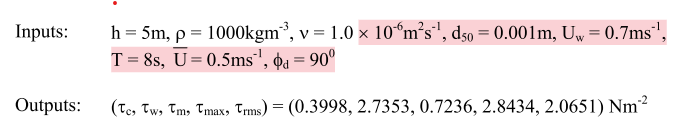

In [8]:
velocity2 = np.array([0.5])
vel_dir2 = np.array([0])
density2 = np.array([1000])
nivel2 = np.array([5])
wv2 = np.array([0.7])
wave_dir2 = np.array([90])
wave_t2 = np.array([8])
sed_size2 = 0.001


print(np.round(shear_wc(velocity2, vel_dir2, density2, nivel2, wv2, wave_dir2, wave_t2, sed_size2), 4))

[[0.3998]
 [2.7353]
 [0.7236]
 [2.8434]
 [0.0269]]


In [9]:
#Applying the functions with the data gathered

M_vel = np.nanmean(M_intp[:, :], 1)
M_dir = np.nanmean(M_dir_intp[:,:], 1)

wv_s = orbital_velocity(data['wave_T_fft'][:], data['wave_H_fft'][:], niveis_intp)
tc, tw, tmw, tmax, ucr = shear_wc(M_vel, M_dir, dens, niveis_intp, wv_s, data['wave_dir_SC'][:], data['wave_T_fft'][:], 0)
    

    

In [ ]:
visc = 1e-3
C_test = np.zeros((len(data['wave_dt']), len(z)))
C_eo_test = np.zeros((len(data['wave_dt']), len(z)))
C_R = np.zeros(len(data['wave_dt']))+1
C_sed = np.zeros(len(data['wave_dt']))
C_dens = np.zeros(len(data['wave_dt']))
C_con = np.zeros(len(data['wave_dt']))
C = np.zeros((len(data['wave_dt']), len(z)))
C_eo = np.zeros((len(data['wave_dt']), len(z)))
C_ws = np.zeros(len(data['wave_dt']))

sed_range = np.arange(0.02,0.065, 0.005)
#Density values from this articles: https://link.springer.com/article/10.1007/s10236-009-0251-0
dens_range = np.array([2600,2500,2400,2300,2200,2100,2000])
aa = np.arange(0.01,1.01, 0.01)
bb = np.arange(0.2,10.1, 0.1)
cc = np.arange(11,61, 1)
conc_range = np.concatenate((aa,bb,cc))
del aa,bb,cc
# Note that to calculate z_r, the sediment size used to estimate Ks is not the same as that used in suspension.
# The D50 value was defined based on the article: 10.5088/atl.2011.33.2.123

value = 0
k = 0.41
B = 1
for i in range(len(data['wave_dt'])):
        for cc in range(len(conc_range)):
            for ss in range(len(sed_range)):
                for dd in range(len(dens_range)):
                    sed_size = sed_range[ss]/1000  #median grain diamenter (m)
                    #Particle fall velocity
                    ws = 2/9*(dens_range[dd]-dens[i])/visc*gv*sed_size**2# (A38)
                    c_ref = conc_range[cc]
                    RO = B*ws/(k*ucr[i])# (A39)
                    z_r = (26*(2*0.150/1000))/k# (A37) - 0.150 is the sediment size to estimate z_R
                    C_eo_test[i,:] = k*ucr[i]*z_r# (A36)
                    C_test[i,:] = c_ref*(1 + (k*ucr[i]*z/C_eo_test[i,:]))**-RO# (A40)
                    cod1 =(np.sum((C_test[i,:] - ssc_intp[i,:]/1000)**2)/28)**0.5 #RMSE
                    if cod1 < C_R[i]:
                        C_R[i] = cod1
                        C_eo[i,:] = C_eo_test[i,:]
                        C_sed[i] = sed_range[ss]
                        C_con[i] = conc_range[cc]  
                        C_ws[i] = ws
                        C[i,:] = C_test[i,:]
                        C_dens[i] = dens_range[dd]-dens[i]
        print('time: '+str(i)+'/'+str(len(data['wave_dt']))+' RMSE: '+str(round(C_R[i]*100,2))+' eo: '+str(round(C_eo[i,0]*10000,2))+' sed_size: '+str(round(C_sed[i],3))+' Co: '+str(round(C_con[i],2)), end='\r')      

In [ ]:
#roots = "C:/Users/guioc/Documents/Art1/SoundSSC/Output_Data/"

with open(roots+'t_mc_fft.pkl', 'wb') as file: # Shear stress for current
    pickle.dump(tc, file)

with open(roots+'t_m_fft.pkl', 'wb') as file: # Mean shear stress for current+wave
    pickle.dump(tmw, file)
    
with open(roots+'t_max_fft.pkl', 'wb') as file: # Maximun shear stress for current+wave
    pickle.dump(tmax, file)
    
with open(roots+'t_mw_array.pkl', 'wb') as file: # Shear stress for wave
    pickle.dump(tw, file)

with open(roots+'ucr_fft.pkl', 'wb') as file: # Shear velocity of flow
    pickle.dump(ucr, file)

with open(roots+'C_R.pkl', 'wb') as file: # RMSE for SSC_rouse X SSC_abs
    pickle.dump(C_R, file)
    
with open(roots+'C_eo.pkl', 'wb') as file: # Residual Turbulent diffusion coefficient
    pickle.dump(C_eo, file)
    
with open(roots+'C_sed.pkl', 'wb') as file: # Sediment size obtained from rouse profile
    pickle.dump(C_sed, file)

with open(roots+'C_con.pkl', 'wb') as file: # Sediment concentration at z = 0
    pickle.dump(C_con, file)
    
with open(roots+'C_ws.pkl', 'wb') as file: # Particle fall velocity
    pickle.dump(C_ws, file)
    
with open(roots+'C_dens.pkl', 'wb') as file: # Sediment density obtained from rouse profile
    pickle.dump(C_dens, file)
    
with open(roots+'ssc_rouse.pkl', 'wb') as file: # Sediment concentration by depth
    pickle.dump(C, file)

with open(roots+'Sal_SC.pkl', 'wb') as file: # Salinity from RS4 Buoy
    pickle.dump(sal_intp, file)
    


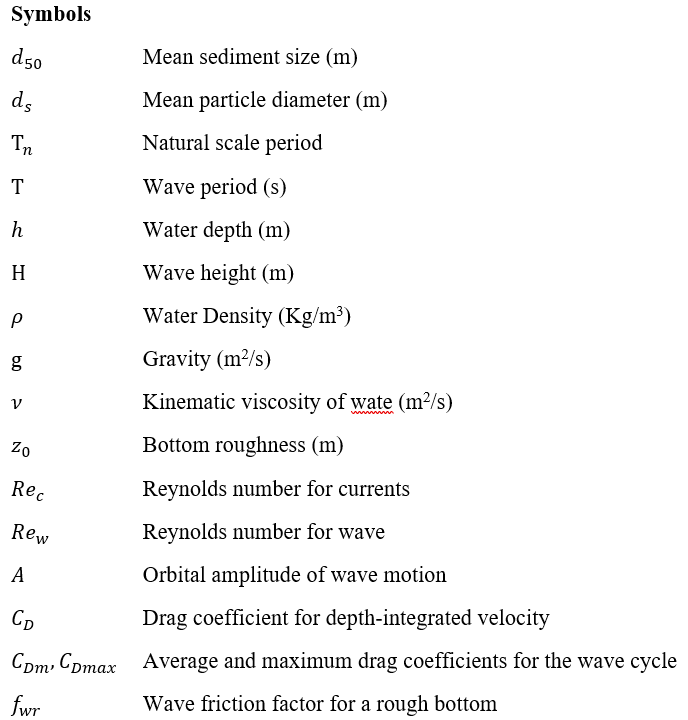

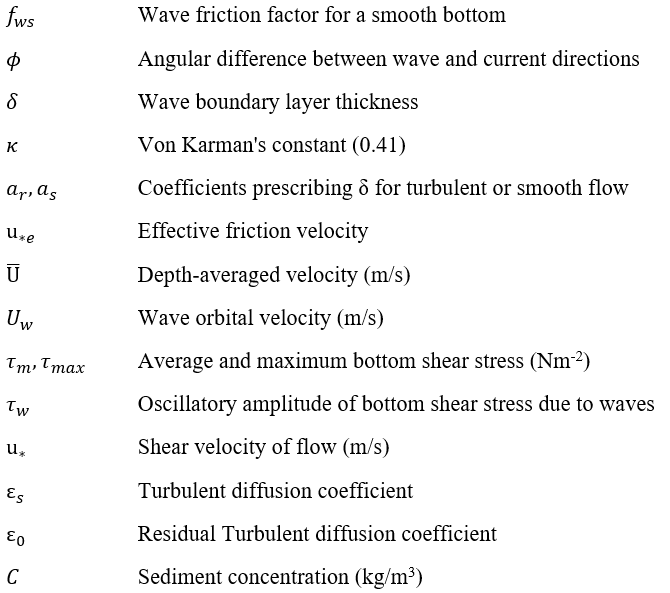

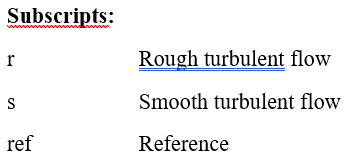

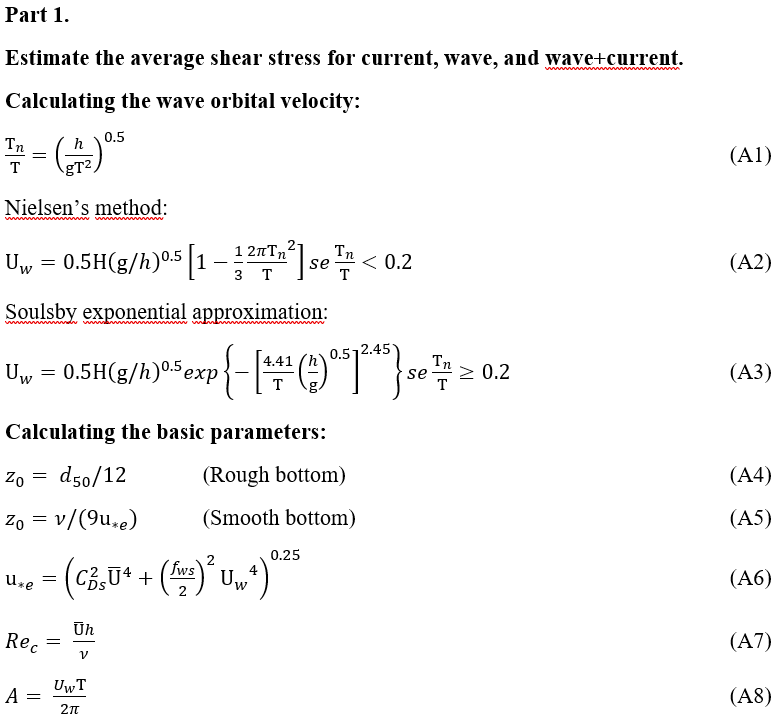

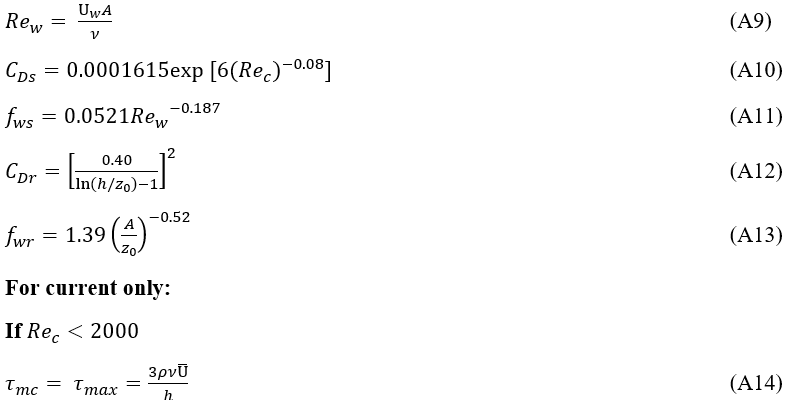

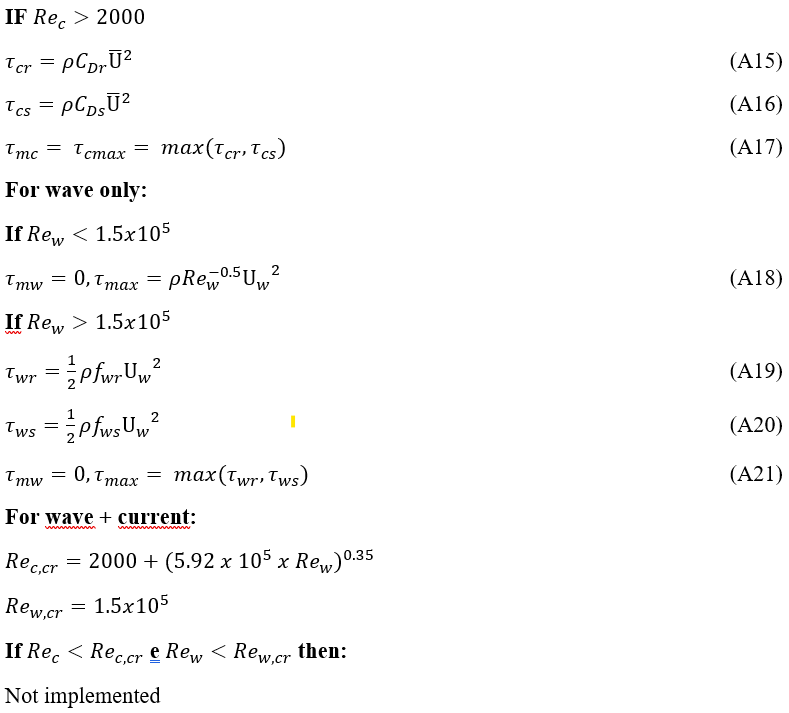

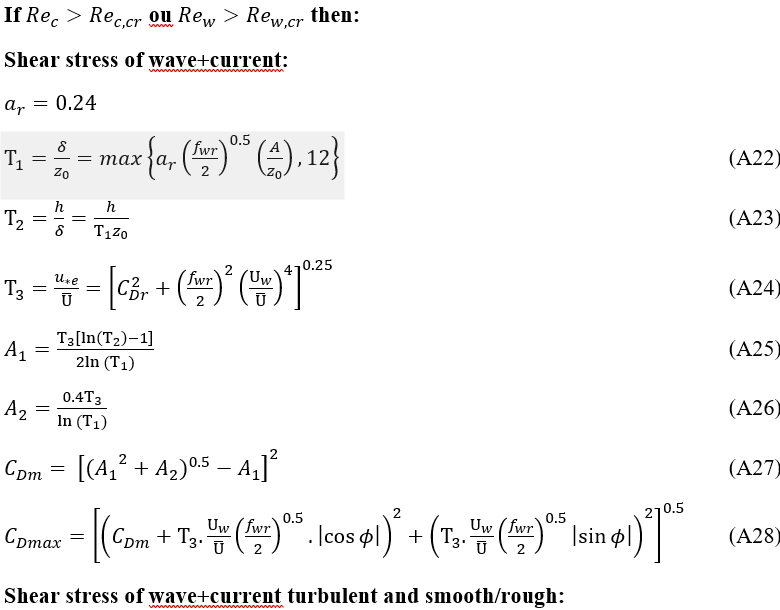

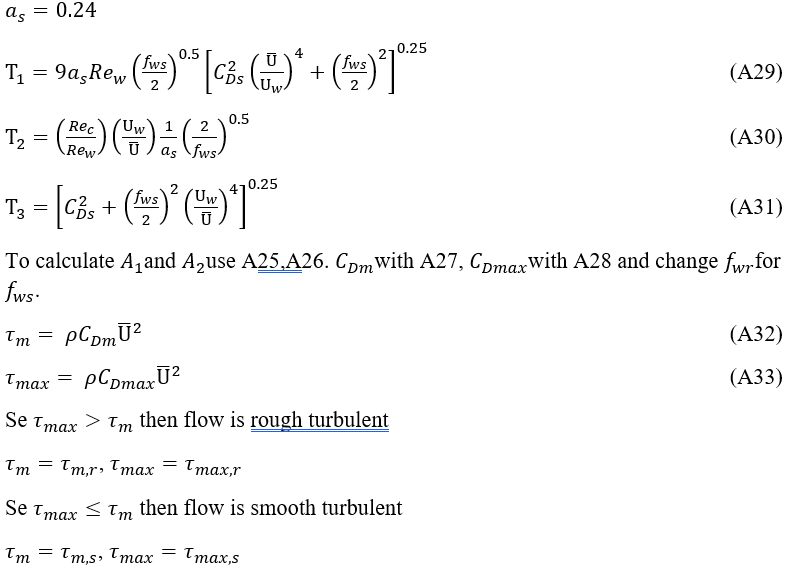

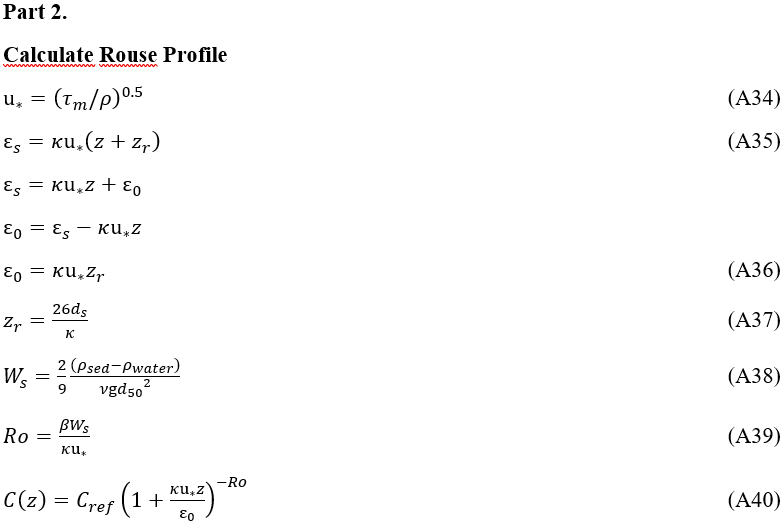